In [5]:
import re
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

data_1 = pd.read_csv('data/bina_az_02102023.csv')
data_2 = pd.read_csv('data/bina_az_new.csv')
data_3 = pd.read_csv('data/bina_az_old.csv')
data_4 = pd.read_csv('data/bina_az_25102023.csv')
data_5 = pd.read_csv('data/bina_az_01112023.csv')
df = pd.concat([data_1, data_2, data_3,data_4,data_5]).drop_duplicates().dropna()
df['is_near_metro'] = (df['description'].str.contains('m\.', case=False) | df['description'].str.contains('metro',case=False)).astype(int)
df = df[df['seller_type'] != 'seller_type']
df[['flat', 'total_flat']] = df['flat_number'].str.split(' / ', expand=True).astype(int)
remove_non_numeric_and_convert_to_float = lambda value: float(re.sub(r'[^\d.]', '', value)) if value else None
df['area_converted'] = df['area'].apply(remove_non_numeric_and_convert_to_float)
df['room_count'] = df['room_count'].astype(int)
df['documents_encoded'] = df['documents'].map({'var': 1, 'yoxdur': 0})
df['is_repair_encoded'] = df['is_repair'].map({'var': 1, 'yoxdur': 0})
df['seller_type_encoded'] = df['seller_type'].map({'vasitəçi (agent)': 0, 'mülkiyyətçi': 1})
df['category_encoded'] = df['category'].map({'Yeni tikili': 0, 'Köhnə tikili': 1})
df['price'] = df['price'].str.replace(' ', '').astype(int)
df = df[df['price']>5000]
df = df[['is_near_metro', 
                 'seller_type_encoded', 
                 'flat', 
                 'total_flat', 
                 'room_count',
                 'area_converted', 
                 'category_encoded',
                 'documents_encoded',
                 'is_repair_encoded', 
                 'price']].drop_duplicates(ignore_index=True)
# Save the cleaned and transformed dataframe to a CSV file
df.to_csv('data/df.csv', index=False)


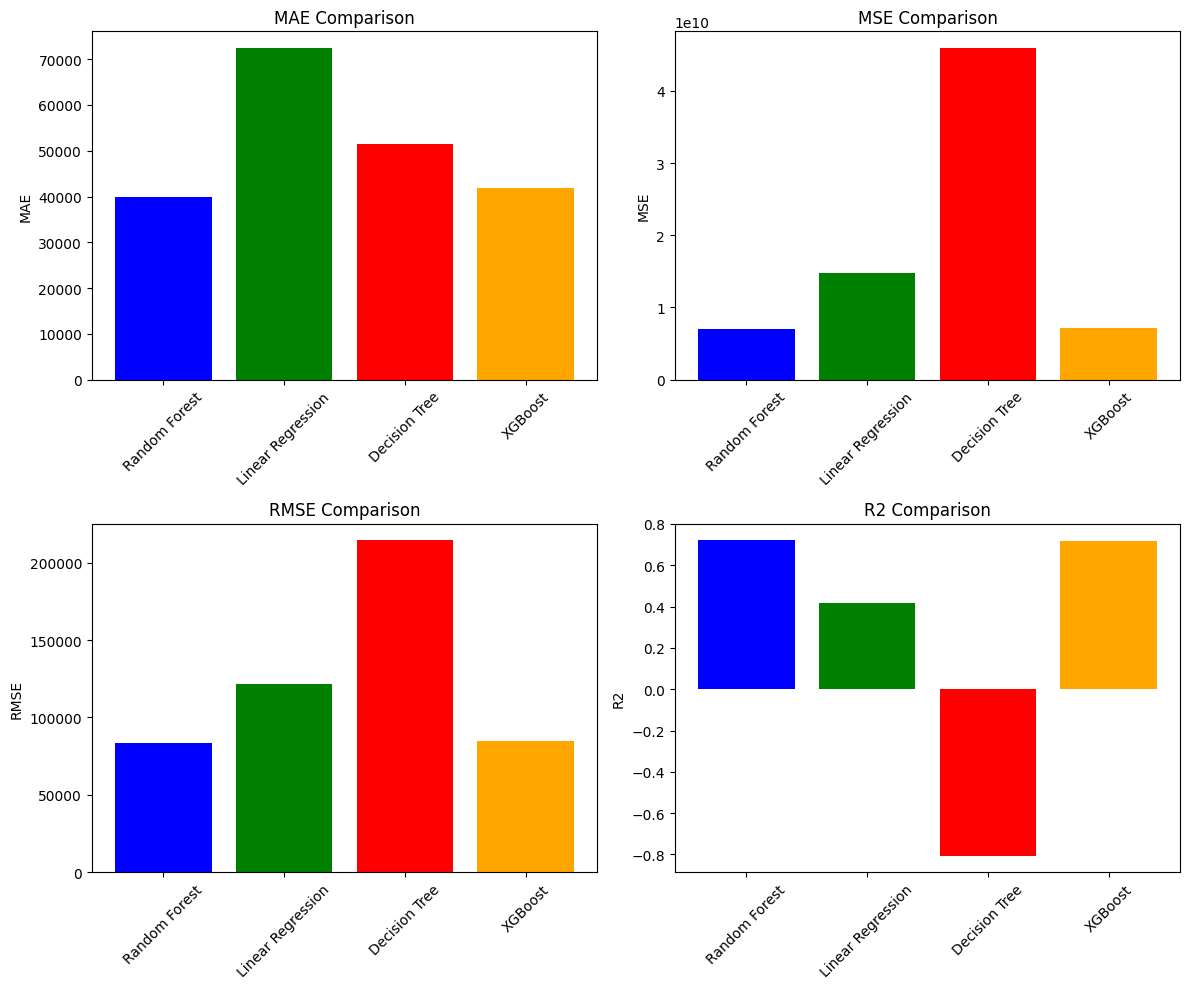

,MAE,MSE,RMSE,R2
Random Forest,39841.651982,7.013949e+09,83749.324389,0.724002
Linear Regression,72453.202363,1.479603e+10,121638.930929,0.417779
Decision Tree,51478.986196,4.596701e+10,214399.192925,-0.808795
XGBoost,41848.609361,7.217877e+09,84958.087935,0.715978


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for training
X = df.drop(columns='price')
y = df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Random Forest': RandomForestRegressor(),
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Store results for each model
results = {}

# Train each model and evaluate performance
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

# Convert results to a DataFrame for easy visualization
results_df = pd.DataFrame(results).T

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Define metrics for comparison
metrics = ['MAE', 'MSE', 'RMSE', 'R2']
for i, metric in enumerate(metrics):
    ax = axs[i//2, i%2]
    ax.bar(results_df.index, results_df[metric], color=['blue', 'green', 'red', 'orange'])
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.set_xticklabels(results_df.index, rotation=45)

plt.tight_layout()
plt.show()

results_df

In [9]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib

# Define the objective function for optimization
def objective(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])

    # Create a RandomForestRegressor with the given hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

# Create an Optuna study to minimize the MSE
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)  # Run 50 trials to find the best hyperparameters

# Get the best hyperparameters
best_params = study.best_params

# Train the RandomForestRegressor with the best parameters
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Predict and evaluate the performance
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

# Save the training columns
training_columns = X.columns.tolist()
with open('training_columns.pkl', 'wb') as f:
    joblib.dump(training_columns, f)

# Save the best trained model
joblib.dump(best_model, 'best_random_forest_model.pkl')

# Display results
best_params, mse_best, rmse_best, r2_best


[I 2024-10-10 19:46:35,374] A new study created in memory with name: no-name-5d7a7939-76bb-48c5-bb11-16da3eb4d5db
[I 2024-10-10 19:46:44,265] Trial 0 finished with value: 6493822667.743809 and parameters: {'n_estimators': 870, 'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 0 with value: 6493822667.743809.
[I 2024-10-10 19:46:48,383] Trial 1 finished with value: 6001195916.073513 and parameters: {'n_estimators': 546, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 6001195916.073513.
[I 2024-10-10 19:46:49,301] Trial 2 finished with value: 6058416444.634091 and parameters: {'n_estimators': 126, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 6001195916.073513.
[I 2024-10-10 19:46:51,720] Trial 3 finished with value: 5959463022.137111 and parameters: {'n_estimators': 133, 'max_depth': 22, 'min_sampl

({'n_estimators': 133,
  'max_depth': 22,
  'min_samples_split': 10,
  'min_samples_leaf': 6,
  'max_features': None},
 np.float64(5959463022.137111),
 np.float64(77197.55839492018),
 0.7654960892682565)